# Sipariş Verisi Analizi ve Servis Alanlarının Belirlenmesi


Açıklama


## Metodoloji


---

## Hazırlık

### Çalışma alanının belirlenmesi


Verileri indirmeden önce, ilgi alanının koordinatlarını tanımlayacağız. Bu koordinatlara dayanarak, veri kümelerini daha ileri işlemeler için kırpabileceğiz ve sonunda seçilen alan için sipariş verisini ve servis alanlarını görüntüleyebileceğiz.

Coğrafi koordinatlar cinsinden bir alanı kolayca tanımlamak için [Bounding Box Tool](https://boundingbox.klokantech.com/) adresine giderek bir bölge seçebilir ve koordinatları alabiliriz. Buradaki değerlerin kullanılabilmesi için sol alt köşeden 'CSV' seçeneğini seçtiğinizden emin olun ve ardından köşeli parantez içindeki değerleri kopyalayın. Koordinatların yanı sıra, grafiklerde ve kaydedilen sonuçlarda kullanılacak alan için bir isim belirtmeniz gerekmektedir. Koordinatların WGS84 koordinat sisteminde (EPSG:4326) belirtilmektedir.


In [1]:
## name of the area
areaname = 'Bursa'
# bbox = [longitude_min, latitude_min, longitude_max, latitude_max]
bbox = [28.753995,40.108817,29.319104,40.336879]


## example:
# areaname = 'Istanbul'
# bbox = [28.966667,40.966667,29.216667,41.116667]

### Kütüphanelerin yüklenmesi


Bu not defterinde aşağıdaki Python kütüphanelerini kullanacağız:

- [pandas](https://pandas.pydata.org/) - Tablo şeklindeki verilerle çalışmak için temel bir veri işleme ve analiz kütüphanesidir.
- [geopandas](https://geopandas.org/) - Coğrafi verileri analiz etmek ve görselleştirmek için pandas'ı genişleten bir kütüphane.
- [psycopg2](https://www.psycopg.org/docs/) - PostgreSQL veritabanları ile bağlantı kurmak ve SQL sorguları çalıştırmak için kullanılan bir veritabanı adaptörüdür.
- [plotly](https://plotly.com/python/) - Etkileşimli grafikler, haritalar ve görselleştirmeler oluşturmak için güçlü bir kütüphane.
- [requests](https://docs.python-requests.org/en/latest/) - HTTP istekleri göndermek ve API'lerden veri almak için kullanılan basit ve etkili bir kütüphane.
- [osmnx](https://osmnx.readthedocs.io/en/stable/) - OpenStreetMap verilerini indirip, analiz edip, görselleştirmek için kullanılan bir kütüphane.

Bu kütüphaneler, coğrafi ve sayısal verilerin indirilmesi, işlenmesi, analiz edilmesi ve görselleştirilmesini sağlar.


In [2]:
# for downloading data and managing files
import os
import requests

# analysis
    # data handling
import pandas as pd
import numpy as np
import random
from typing import List, Dict, Tuple, Optional
    # density and geometry
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.spatial import cKDTree
    # clustering and scaling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
    # clustering evaluation
from sklearn.metrics import silhouette_score

# working with geospatial data (shapefile, GeoJSON, etc.)
import geopandas as gpd
from shapely.geometry import box, Point, Polygon, MultiPolygon, MultiPoint, LineString

# for interactive graphs and map-based visualizations
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
import contextily as ctx
import seaborn as sns 

# for downloading, analyzing and visualizing OSM data
import osmnx as ox
import networkx as nx

# for raster data
import rasterio
from rasterio.warp import transform_bounds, reproject, Resampling, calculate_default_transform
from rasterio.features import rasterize
from scipy.ndimage import gaussian_filter

# for warnings
import warnings

# fancy progress bar
from tqdm import tqdm


In [3]:
# no need to show warnings :)
warnings.filterwarnings('ignore')

### Dosya yapısının oluşturulması


Analiz sürecinde verilerin ve çıktıların düzenli bir şekilde saklanabilmesi için klasörleme sistemi oluşturuyoruz. Böylece veri dosyaları ve görseller gibi farklı içerikler kolayca yönetilebilir ve tekrar erişilebilir.

In [4]:
# define the folder for the workflow
workflow_folder = 'ORDERS_SERVICE_AREA'

# check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [5]:
# define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

### Çalışma alanına ait coğrafi verilerin temini ve görüntülenmesi

#### Vektörel Veriler

Yol verileri için OSMnx kütüphanesi aracılığılıyla OpenStreetMap'ten ve idari sınırlar için Bursa Açık Veri Platformu'nu kullanıyoruz. Verilerin güncelliğini korumak maksatıyla bir defaya mahsus webten temin edilmesi gerekmektedir ve bu işlem ortalama bir internet bağlantısı ile bir dakikada gerçekleşmektedir.

In [6]:
# convert bounding box to polygon
def create_bbox_polygon(bbox):
    return box(*bbox)

# clip roads to bbox 4326
def clip_roads_to_bbox(roads, bbox):
    bbox_geom = box(*bbox)
    nodes_within_bbox = [
        n for n, data in roads.nodes(data=True)
        if bbox_geom.contains(Point(data['x'], data['y']))
    ]
    return roads.subgraph(nodes_within_bbox)

# download road network or if it's downloaded before, load from file (it takes a minute to download with an average network speed)
def get_road_network(bbox, filepath):
    if os.path.exists(filepath):
        print("Yol ağı dosyadan yükleniyor")
        return ox.load_graphml(filepath)
    else:
        print("Yol ağı indiriliyor")
        polygon = create_bbox_polygon(bbox)
        G = ox.graph_from_polygon(polygon, network_type='drive')
        ox.save_graphml(G, filepath)
        return G

def convert_road_network_to_meters(roads):
    roads_3857 = ox.project_graph(roads, to_crs='EPSG:3857')
    return roads_3857

# download admin boundaries by area name or if it's downloaded before, load from file
def get_bursa_admin_data(districts_filepath, nbh_filepath):
    districts_gdf = gpd.GeoDataFrame()
    nbh_gdf = gpd.GeoDataFrame()
    
    # ilce
    if os.path.exists(districts_filepath):
        print("İlçe verileri dosyadan yükleniyor")
        districts_gdf = gpd.read_file(districts_filepath)
    else:
        print("İlçe verileri Bursa Açık Veri Portalından indiriliyor")
        
        try:
            # ilce (bursa acik veri portalindan)
            url = "https://bapi.bursa.bel.tr/apigateway/bbbAcikVeri_Cbs/ILCE"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            districts_gdf = gpd.GeoDataFrame.from_features(data['features'])
            districts_gdf.set_crs('EPSG:4326', inplace=True)
            columns_to_keep = ['AD', 'ID', 'MERKEZILCEMI', 'KIMLIKNO', 'geometry']
            existing_columns = [col for col in columns_to_keep if col in districts_gdf.columns]
            districts_gdf = districts_gdf[existing_columns]
            
            # renaming columns for consistency
            districts_gdf = districts_gdf.rename(columns={'AD': 'name', 'ID': 'guid', 'MERKEZILCEMI': 'center_district', 'KIMLIKNO': 'id'})
            
            # removing rows with null geometry
            districts_gdf = districts_gdf.dropna(subset=['geometry'])
            
            # saving to file
            districts_gdf.to_file(districts_filepath)
            print(f"İlçe verileri başarıyla indirildi: {len(districts_gdf)} öğe")
            
        except Exception as e:
            print(f"Hata: İlçe verileri alınamadı: {e}")
            districts_gdf = gpd.GeoDataFrame()
    
    # mahalle
    if os.path.exists(nbh_filepath):
        print("Mahalle verileri dosyadan yükleniyor")
        nbh_gdf = gpd.read_file(nbh_filepath)
    else:
        print("Mahalle verileri Bursa Açık Veri Portalından indiriliyor")
        
        try:
            # mahalle (bursa acik veri portalindan)
            url = "https://bapi.bursa.bel.tr/apigateway/bbbAcikVeri_Cbs/Mahalle"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            nbh_gdf = gpd.GeoDataFrame.from_features(data['features'])
            nbh_gdf.set_crs('EPSG:4326', inplace=True)
            
            # removing unnecessary columns
            columns_to_keep = ['AD', 'ID', 'ILCEID', 'KIMLIKNO', 'geometry']
            existing_columns = [col for col in columns_to_keep if col in nbh_gdf.columns]
            nbh_gdf = nbh_gdf[existing_columns]
            
            # renaming columns for consistency
            nbh_gdf = nbh_gdf.rename(columns={'AD': 'name', 'ID': 'guid', 'ILCEID': 'district_id', 'KIMLIKNO': 'id'})
            
            # removing rows with null geometry
            nbh_gdf = nbh_gdf.dropna(subset=['geometry'])
            
            nbh_gdf.to_file(nbh_filepath)
            print(f"Mahalle verileri başarıyla indirildi: {len(nbh_gdf)} öğe")
            
        except Exception as e:
            print(f"Hata: Mahalle verileri alınamadı: {e}")
            nbh_gdf = gpd.GeoDataFrame()
    
    return districts_gdf, nbh_gdf
        
# sınırların ve yolların görselleştirilmesi
def plot_boundaries(districts, neighbourhoods, roads, area_name, bbox):
    fig, ax = plt.subplots(figsize=(12, 10))
    use_crs = 'EPSG:3857'

    # veri çizimi v2
    if not districts.empty:
        districts.to_crs(use_crs).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.7)
    
    if not neighbourhoods.empty:
        neighbourhoods.to_crs(use_crs).plot(ax=ax, color='#FAD7A0', edgecolor='black', alpha=0.05)
    
    if roads is not None:
        edges = ox.graph_to_gdfs(roads, nodes=False, edges=True).to_crs(use_crs)
        road_colors = {
            'motorway': ('#E74C3C', 1.5),
            'trunk':    ('#D35400', 1.5),
            'primary':  ('#F1C40F', 1.5),
            'secondary':('#27AE60', 1),
            'tertiary': ('#2980B9', 1)
        }
        for rt, (color, lw) in road_colors.items():
            mask = edges['highway'].apply(lambda hw: rt in hw if isinstance(hw, list) else hw == rt)
            edges[mask].plot(ax=ax, color=color, linewidth=lw, alpha=0.8)

    # alan sınırları
    bbox_gdf = gpd.GeoDataFrame(geometry=[box(*bbox)], crs='EPSG:4326').to_crs(use_crs)
    bbox_gdf.head()
    minx, miny, maxx, maxy = bbox_gdf.total_bounds
    buffer = max((maxx - minx), (maxy - miny)) * 0.1
    ax.set_xlim(bbox_gdf.total_bounds[0] - 5000, bbox_gdf.total_bounds[2] + 5000)
    ax.set_ylim(bbox_gdf.total_bounds[1] - 5000, bbox_gdf.total_bounds[3] + 5000)

    # basemap
    zoom = 12 if max(bbox[2] - bbox[0], bbox[3] - bbox[1]) < 0.1 else 10
    try:
        ctx.add_basemap(ax, zoom=zoom, source=ctx.providers.CartoDB.Positron)
    except:
        print("Basemap yüklenemedi")

    # görsel ayarlar
    ax.set_xlabel("X (metre)")
    ax.set_ylabel("Y (metre)")
    ax.set_title(f"OpenStreetMap {area_name} ve Bursa Açık Veri Portalı verileri", fontsize=15, fontweight='bold', color='#2C3E50')
    
    # legend v2
    legend_elements = [
        mlines.Line2D([], [], color='black', lw=2, label='İlçe Sınırı'),
        mlines.Line2D([], [], color='black', lw=1, alpha=0.3, label='Mahalle Sınırı'),
        mlines.Line2D([], [], color='#E74C3C', lw=2, label='Otoyol'),
        mlines.Line2D([], [], color='#D35400', lw=1.5, label='Ekspres Yol'),
        mlines.Line2D([], [], color='#F1C40F', lw=1.2, label='Ana Yol'),
        mlines.Line2D([], [], color='#27AE60', lw=1, label='İkincil Yol'),
        mlines.Line2D([], [], color='#2980B9', lw=1, label='Tali Yol'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=8, frameon=True, title="Lejant")
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{area_name}_osm_boundaries.png'), dpi=600, bbox_inches='tight')
    plt.show()
    
# main workflow
def analyze_area(bbox, area_name, data_folder=data_dir, plots_folder=plot_dir):
    
    os.makedirs(data_folder, exist_ok=True)
    os.makedirs(plots_folder, exist_ok=True)
    
    # setting file paths
    road_file = os.path.join(data_folder, f'{area_name}_roads.graphml')
    districts_file = os.path.join(data_folder, f'{area_name}_districts.geojson')
    nbh_file = os.path.join(data_folder, f'{area_name}_neighbourhoods.geojson')
    
    print(f"{area_name} bölgesi için veri yükleniyor")
    print("-" * 10)
    
    # yollar (bbox ile kapsam alanı artıyor)
    roads = get_road_network(bbox, road_file)
    roads = clip_roads_to_bbox(roads, bbox)
    
    # bolge idari sinirlar
    districts , neighbourhoods = get_bursa_admin_data(districts_file, nbh_file)
    
    print(f"Veri Özeti:")
    print(f"- Yollar: {len(roads.nodes)} düğüm, {len(roads.edges)} kenar")
    print(f"- İlçeler: {len(districts)} öğe")
    print(f"- Mahalleler: {len(neighbourhoods)} öğe")
    
    # data vis
    plot_boundaries(districts, neighbourhoods, roads, area_name, bbox)
    
    return roads, districts, neighbourhoods

# sample usage
# roads, districts, neighbourhoods = analyze_area(bbox, area_name)

Bursa bölgesi için veri yükleniyor
----------
Yol ağı dosyadan yükleniyor
İlçe verileri dosyadan yükleniyor
Mahalle verileri dosyadan yükleniyor
Veri Özeti:
- Yollar: 46929 düğüm, 132322 kenar
- İlçeler: 17 öğe
- Mahalleler: 1074 öğe


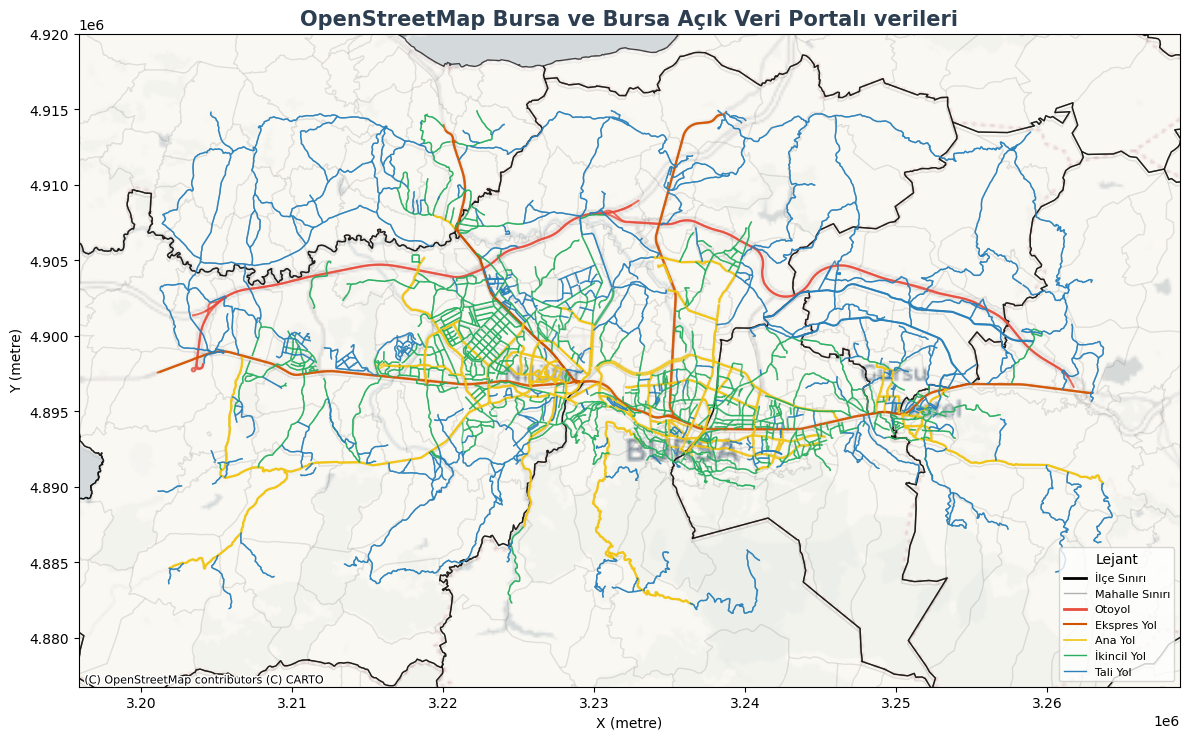

In [7]:
roads, districts, neighbourhoods = analyze_area(bbox, areaname)

roads_3857 = convert_road_network_to_meters(roads)

#### Raster Veri

SRTM açıklama

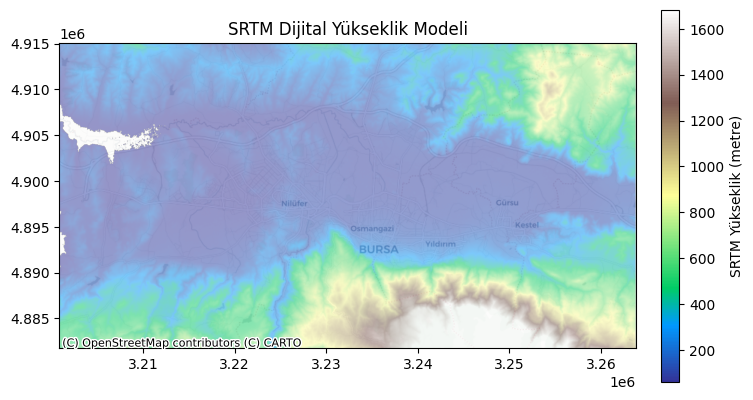

Piksel boyutu: 32.44 x 32.44 mt
Geçerli yükseklik aralığı: 62.00 - 1683.00 m


In [8]:
# notebookta olduğundan mı bilmiyorum ama proj ortamlarını temizlemezsem çalışmıyor 
# https://rasterio.readthedocs.io/en/stable/faq.html#why-can-t-rasterio-find-proj-db-rasterio-versions-1-2-0
# [sonra bak]
    # alos palsar'da 12.5 m çözünürlük vardı ancak DEM üretim süreci çok uzun sürecek ve maliyetler çok yüksek olacağı için SRTM'e geçiş yaptım
[os.environ.pop(k, None) for k in ['PROJ_LIB', 'PROJ_DATA']]

# SRTM raster verisi için okuma ve görselleştirme
srtm_path = r"..\data\working_area_srtm.tif"

with rasterio.open(srtm_path) as src:
    data = src.read(1)
    bounds = src.bounds
    # nodata değerini kullanarak geçersiz pikselleri filtrele
    mask = data != src.nodata if src.nodata is not None else np.ones_like(data, dtype=bool)
    valid = data[mask]

    # Yükseklik aralığı için yüzde 2-98 dilimlerini hesapla
    vmin, vmax = np.percentile(valid, [2, 98])

    target_crs = 'EPSG:3857'

    data_plot = data
    mask_plot = mask
    bounds_plot = bounds
    crs_plot = src.crs.to_string()
    pixel_width = src.transform.a
    pixel_height = -src.transform.e

    if src.crs.to_string() != target_crs:
        bounds_plot = transform_bounds(src.crs, target_crs, *bounds)
        dst_transform, w, h = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        dst_array = np.empty((h, w), dtype=np.float32)
        reproject(
            source=data,
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )
        data_plot = dst_array
        mask_plot = ~np.isnan(data_plot)
        valid_plot = data_plot[mask_plot]
        vmin, vmax = np.percentile(valid_plot, [2, 98])
        crs_plot = target_crs
        pixel_width = dst_transform.a
        pixel_height = -dst_transform.e

    # plot
    fig, ax = plt.subplots(figsize=(8, 8))
    display_data = np.ma.masked_where((~mask_plot) | (data_plot <= np.percentile(data_plot[mask_plot], 1)), data_plot)
    img = ax.imshow(display_data, extent=[bounds_plot[0], bounds_plot[2], bounds_plot[1], bounds_plot[3]], origin='upper', cmap='terrain', vmin=vmin, vmax=vmax)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=crs_plot, alpha=0.5)
    cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("SRTM Yükseklik (metre)")
    plt.title("SRTM Dijital Yükseklik Modeli")
    plt.axis('on')
    plt.show()

raster_values = data[mask].flatten()
df_raster = pd.DataFrame({'value': raster_values})

print(f"Piksel boyutu: {pixel_width:.2f} x {pixel_height:.2f} mt")
print(f"Geçerli yükseklik aralığı: {vmin:.2f} - {vmax:.2f} m")

### Çalışma alanına ait demografik verilerin temini

31 Aralık 2024 tarihli Adrese Dayalı Nüfus Kayıt Sistemi (ADNKS) verisi, TÜİK web sitesinden temin edilmiştir.

Veri, mahalle düzeyinde toplam nüfus, cinsiyet ve yaş grubu gibi demografik bilgileri içermektedir.

In [9]:
# tuik doesn't allow to download data with web requests so we have to use local file
file_path = '../data/bursa_nbh_pop.xls'

try:
    bursa_neighbourhood = pd.read_excel(file_path)
    print('Adrese Dayalı Nüfus Kayıt Sistemi verisinden mahalle nüfus verisi okundu.')
except Exception as e:
    print(f'CSV dosyası okunamadı: {e}')
    
file_path = '../data/bursa_district_age.xls'

try:
    bursa_district_age = pd.read_excel(file_path)
    print('Adrese Dayalı Nüfus Kayıt Sistemi verisinden ilçe yaş verisi okundu.')
except Exception as e:
    print(f'CSV dosyası okunamadı: {e}')

Adrese Dayalı Nüfus Kayıt Sistemi verisinden mahalle nüfus verisi okundu.
Adrese Dayalı Nüfus Kayıt Sistemi verisinden ilçe yaş verisi okundu.


### Verinin çalışma alanına uygun hale getirilmesi

TÜİK verilerinin ham formatındaki başlık satırları ve gereksiz sütunlar nedeniyle veriyi temizledikten sonra, mahalle ve ilçe bilgilerini içeren metinleri ayrıştırarak il, ilçe, belediye, mahalle gibi coğrafi bileşenleri ayrı sütunlara çıkarıyoruz.

In [10]:
# fixing the column names
bursa_nbh_fixed = bursa_neighbourhood.copy()
bursa_nbh_fixed.columns = bursa_nbh_fixed.iloc[3]
bursa_nbh_fixed = bursa_nbh_fixed.drop(index=range(0, 5)).reset_index(drop=True)
bursa_nbh_fixed = bursa_nbh_fixed.iloc[:, -2:]
bursa_nbh_fixed.columns = ['mahalle', 'nufus']

# parse 'mahalle' column: city(district/municipality/neighbourhood)-id
def parse_mahalle(val):
    main, id = val.rsplit('-', 1)
    city, rest = main.split('(', 1)
    rest = rest.rstrip(')')
    parts = rest.split('/')
    district, municipality, neighbourhood = parts
    return pd.Series([city.strip(), district, municipality, neighbourhood, id])

parsed = bursa_nbh_fixed['mahalle'].apply(parse_mahalle)
bursa_nbh_fixed = pd.concat([parsed, bursa_nbh_fixed['nufus']], axis=1)
bursa_nbh_fixed.columns = ['city', 'district', 'municipality', 'neighbourhood', 'id', 'nufus']

bursa_district_age_fixed = bursa_district_age.copy()
bursa_district_age_fixed = bursa_district_age_fixed.drop(bursa_district_age_fixed.columns[0], axis=1)
bursa_district_age_fixed.columns = bursa_district_age_fixed.iloc[1]
bursa_district_age_fixed = bursa_district_age_fixed.drop(index=[0,1,2,3]).reset_index(drop=True)
bursa_district_age_fixed = bursa_district_age_fixed.rename(columns={bursa_district_age_fixed.columns[0]: 'ilce'})

# parse 'ilce' column: city(district)-id
def parse_ilce(val):
    main, id = val.rsplit('-', 1)
    city, district = main.split('(')
    district = district.rstrip(')')
    return pd.Series([city.strip(), district.strip(), id.strip()])

parsed_district = bursa_district_age_fixed['ilce'].apply(parse_ilce)
parsed_district.columns = ['city', 'district', 'id']
bursa_district_age_fixed = pd.concat([parsed_district, bursa_district_age_fixed], axis=1)
bursa_district_age_fixed = bursa_district_age_fixed.drop(columns=['ilce'])

### Sipariş ve Depo Verilerinin Temini

Açıklama

Sipariş verisi okundu.
Depo verisi okundu.


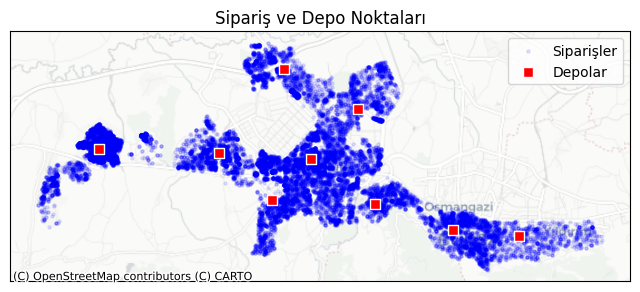

In [11]:
def load_data(path, name):
    try:
        df = pd.read_csv(path)
        print(f'{name} verisi okundu.')
        return df
    except Exception as e:
        print(f'{name} verisi okunamadı: {e}')
        return None

def find_coords(df):
    cols = {col.lower(): col for col in df.columns}
    try:
        return cols['longitude'], cols['latitude']
    except KeyError:
        raise KeyError(f"{df} verisinde 'longitude' ve/veya 'latitude' kolonları bulunamadı.")

order_df = load_data('../data/order.csv', 'Sipariş')
wh_df = load_data('../data/warehouse.csv', 'Depo')

if order_df is not None and wh_df is not None:
    s_long, s_lat = find_coords(order_df)
    w_long, w_lat = find_coords(wh_df)

    order_gdf = gpd.GeoDataFrame(order_df, geometry=gpd.points_from_xy(order_df[s_long], order_df[s_lat]), crs="EPSG:4326").to_crs(epsg=3857)
    wh_gdf = gpd.GeoDataFrame(wh_df, geometry=gpd.points_from_xy(wh_df[w_long], wh_df[w_lat]), crs="EPSG:4326").to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(8, 5))
    order_gdf.plot(ax=ax, markersize=5, color='blue', label='Siparişler', alpha=0.1)
    wh_gdf.plot(ax=ax, markersize=50, color='red', marker='s', label='Depolar', edgecolor='white', linewidth=1)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    # 3857 projeksiyonu için eksen etiketlerini kaldır
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.legend()
    plt.title('Sipariş ve Depo Noktaları')
    plt.savefig(plot_dir + '/' + areaname + '_orders_warehouses.png')
    plt.show()
else:
    print('veri okunamadı')
    order_gdf = None
    wh_gdf = None 


---

## Sipariş Verisinin Mekansal Analizi

Açıklama

### Isı Haritası

Açıklama

#### Sipariş bazında

Açıklama

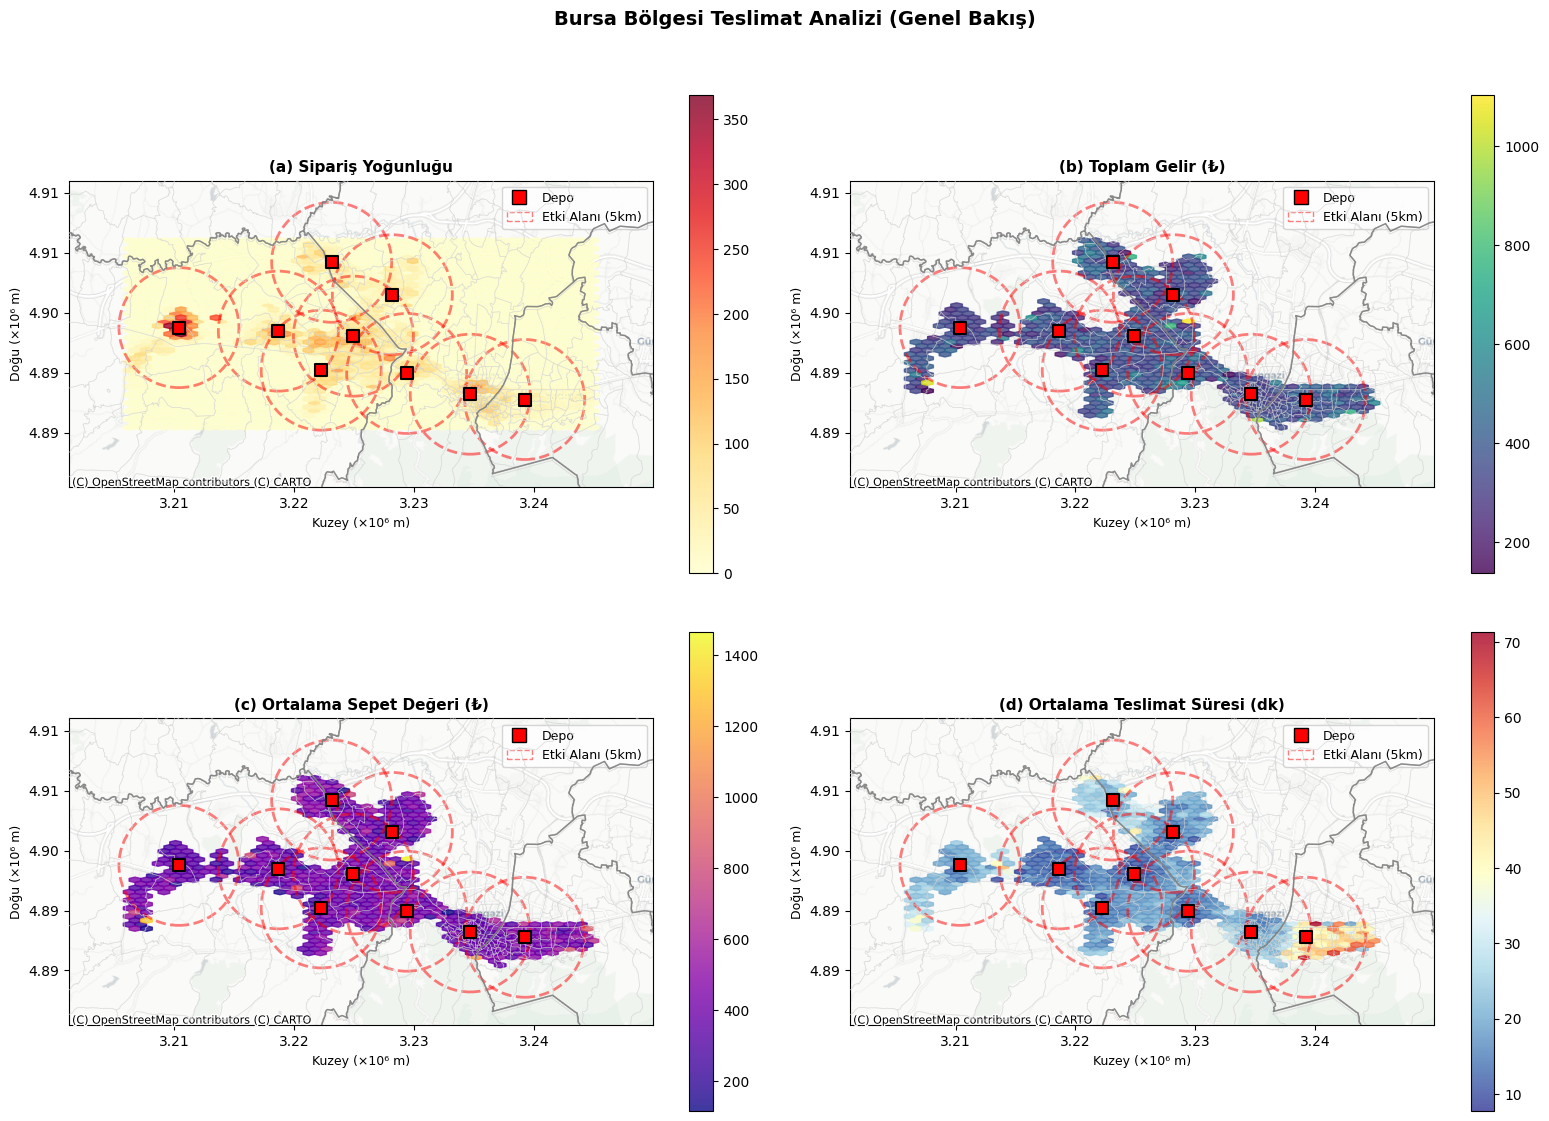

In [12]:
# convert to 3857 for analysis
order_3857 = order_gdf.to_crs(epsg=3857)
wh_3857 = wh_gdf.to_crs(epsg=3857)
x, y = order_3857.geometry.x.values, order_3857.geometry.y.values
w_x, w_y = wh_3857.geometry.x.values, wh_3857.geometry.y.values

revenue = order_gdf['revenue'].values
basket = order_gdf['basket_value'].values
delivery = order_gdf['delivery duration'].values

districts_3857 = districts.to_crs(epsg=3857)
nbh_3857 = neighbourhoods.to_crs(epsg=3857)

maps = [
    ('Sipariş Yoğunluğu', None, 'YlOrRd'),
    ('Toplam Gelir (₺)', revenue, 'viridis'),
    ('Ortalama Sepet Değeri (₺)', basket, 'plasma'),
    ('Ortalama Teslimat Süresi (dk)', delivery, 'RdYlBu_r')
]
labels = ['(a)', '(b)', '(c)', '(d)']
filenames = ['order_density', 'revenue_distribution', 'basket_value', 'delivery_duration']

def plot_hex(ax, data, cmap, title, label, single=False):
    districts_3857.boundary.plot(ax=ax, linewidth=1, edgecolor='grey', alpha=0.7, zorder=7)
    nbh_3857.boundary.plot(ax=ax, linewidth=0.5, edgecolor='lightgrey', alpha=0.5, zorder=6)
    # hexbins (need a fix)
    hb = ax.hexbin(x, y, C=data, gridsize=40, cmap=cmap, alpha=0.8, zorder=3)
    plt.colorbar(hb, ax=ax, shrink=0.8)
    # warehouse and buffer
    wh_handles = []
    buffer_handles = []
    for wx, wy in zip(w_x, w_y):
        # warehouse
        wh = ax.scatter(wx, wy, s=80, c='red', marker='s', edgecolor='black', linewidth=1.5, zorder=8, label='Depo')
        # buffer
        buf = ax.add_patch(plt.Circle((wx, wy), 5000, fill=False, color='red', linestyle='--', alpha=0.5, linewidth=2, zorder=5, label='Etki Alanı (5km)'))
        wh_handles.append(wh)
        buffer_handles.append(buf)
    #zoom into boundaries
    ax.set_xlim(order_3857.total_bounds[0] - 5000, order_3857.total_bounds[2] + 5000)
    ax.set_ylim(order_3857.total_bounds[1] - 5000, order_3857.total_bounds[3] + 5000)
    ax.set_aspect('equal')
    ax.set_title(f'{label} {title}', fontsize=11, weight='bold')
    ax.set_xlabel('Kuzey (×10⁶ m)', fontsize=9)
    ax.set_ylabel('Doğu (×10⁶ m)', fontsize=9)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val/1e6:.2f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val/1e6:.2f}'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)

    # custom legend
    wh_legend = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, markeredgecolor='black', label='Depo')
    buffer_legend = mpatches.Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=1, alpha=0.5, label='Etki Alanı (5km)')
    ax.legend(handles=[wh_legend, buffer_legend], loc='upper right', fontsize=9, frameon=True)

    if single:
        plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'{areaname.capitalize()} Bölgesi Teslimat Analizi (Genel Bakış)', fontsize=14, weight='bold')

# saving plots
for i, (title, data, cmap) in enumerate(maps):
    ax = axes[i//2, i%2]
    plot_hex(ax, data, cmap, title, labels[i])
    fig_single, ax_single = plt.subplots(figsize=(12, 9))
    plot_hex(ax_single, data, cmap, title, labels[i], single=True)
    fig_single.savefig(f"{plot_dir}/{areaname}_{filenames[i]}.png", dpi=600)
    plt.close(fig_single)

plt.tight_layout()
plt.show()

#### Mahalle bazında

Açıklama

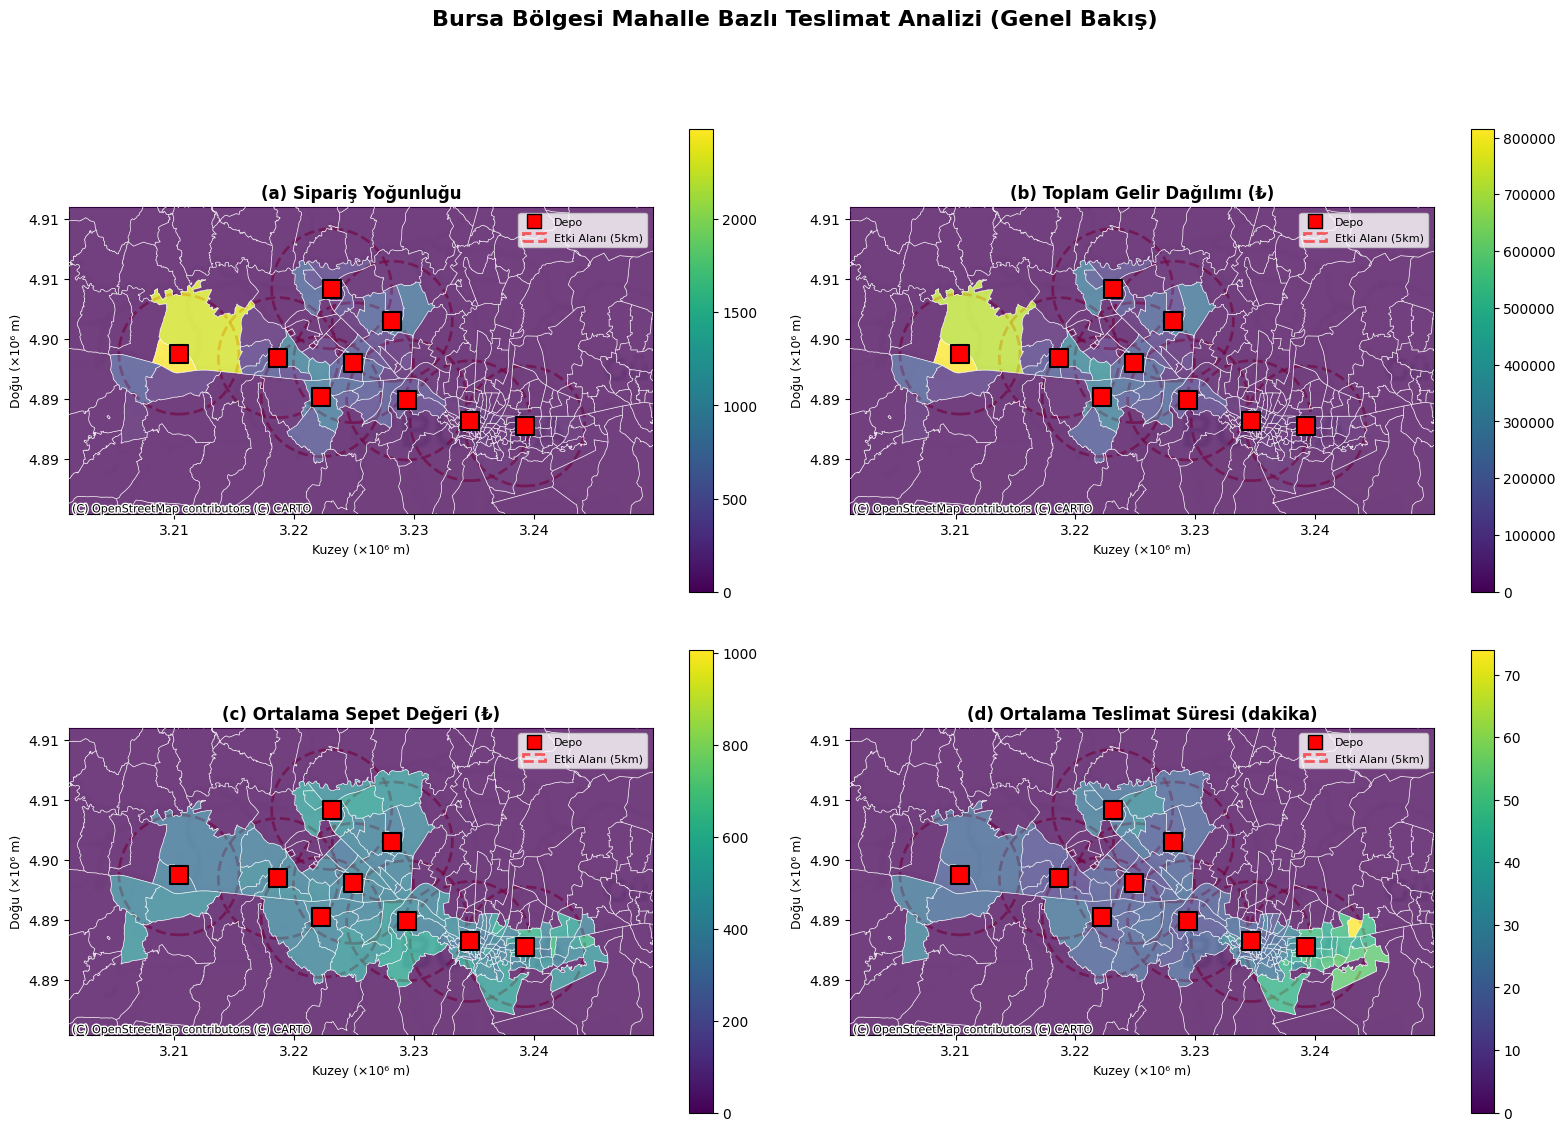

In [13]:
def nbh_based_analysis(order_gdf, nbh_gdf, wh_gdf):
    order_3857 = order_gdf.to_crs(epsg=3857)
    nbh_3857 = nbh_gdf.to_crs(epsg=3857)
    wh_3857 = wh_gdf.to_crs(epsg=3857)
    # spatial join to get mahalle-based statistics
    order_neighbourhood = gpd.sjoin(order_3857, nbh_3857, how='left', predicate='within')
    stats = order_neighbourhood.groupby('index_right').agg(
        revenue_sum=('revenue', 'sum'),
        revenue_mean=('revenue', 'mean'),
        revenue_count=('revenue', 'count'),
        basket_value_mean=('basket_value', 'mean'),
        basket_value_std=('basket_value', 'std'),
        delivery_duration_mean=('delivery duration', 'mean'),
        delivery_duration_std=('delivery duration', 'std')
    ).round(2).rename(columns={
        'revenue_sum': 'toplam_gelir',
        'revenue_mean': 'ortalama_gelir',
        'revenue_count': 'siparis_sayisi',
        'basket_value_mean': 'ortalama_sepet',
        'basket_value_std': 'sepet_std',
        'delivery_duration_mean': 'ortalama_teslimat',
        'delivery_duration_std': 'teslimat_std'
    })
    nbh_analysis = nbh_3857.reset_index().merge(stats, left_on='index', right_index=True, how='left')
    cols = ['toplam_gelir', 'ortalama_gelir', 'siparis_sayisi', 'ortalama_sepet', 'sepet_std', 'ortalama_teslimat', 'teslimat_std']
    nbh_analysis[cols] = nbh_analysis[cols].fillna(0)
    return nbh_analysis, wh_3857

def plot_neighbourhood(nbh_analysis, wh_3857, metrics, bounds, plot_dir, areaname="bolge"):
    os.makedirs(plot_dir, exist_ok=True)
    for metric, (label, title, filename) in metrics.items():
        fig, ax = plt.subplots(figsize=(12, 9))
        nbh_analysis.plot(column=metric, ax=ax, legend=True, cmap='viridis', edgecolor='white', linewidth=0.5,
                            legend_kwds={'shrink': 0.8, 'aspect': 20}, alpha=0.75, zorder=3)
        wh_3857.plot(ax=ax, color='red', marker='s', markersize=150, edgecolor='black', linewidth=1.5, zorder=4)
        for _, row in wh_3857.iterrows():
            ax.add_patch(Circle((row.geometry.x, row.geometry.y), 5000, fill=False, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=2))
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)
        ax.set_title(f'{label} {title}', fontsize=13, weight='bold')
        ax.set_xlabel('Kuzey (×10⁶ m)', fontsize=10)
        ax.set_ylabel('Doğu (×10⁶ m)', fontsize=10)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.set_xlim(bounds[0] - 5000, bounds[2] + 5000)
        ax.set_ylim(bounds[1] - 5000, bounds[3] + 5000)
        ax.set_aspect('equal')
        depo_leg = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, markeredgecolor='black', label='Depo')
        buffer_leg = mpatches.Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=2, alpha=0.6, label='Etki Alanı (5km)')
        ax.legend(handles=[depo_leg, buffer_leg], loc='upper right', fontsize=9)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"{areaname}_nbh_{filename}.png"), dpi=300, bbox_inches='tight')
        plt.close(fig)
    # 2x2 genel görünüm
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{areaname.capitalize()} Bölgesi Mahalle Bazlı Teslimat Analizi (Genel Bakış)', fontsize=16, weight='bold')
    for ax, (metric, (label, title, _)) in zip(axes.flat, metrics.items()):
        nbh_analysis.plot(column=metric, ax=ax, legend=True, cmap='viridis', edgecolor='white', linewidth=0.5,
                            legend_kwds={'shrink': 0.8, 'aspect': 20}, alpha=0.75, zorder=3)
        wh_3857.plot(ax=ax, color='red', marker='s', markersize=150, edgecolor='black', linewidth=1.5, zorder=4)
        for _, row in wh_3857.iterrows():
            ax.add_patch(Circle((row.geometry.x, row.geometry.y), 5000, fill=False, color='red', linestyle='--', alpha=0.6, linewidth=2, zorder=2))
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)
        ax.set_title(f'{label} {title}', fontsize=12, weight='bold')
        ax.set_xlabel('Kuzey (×10⁶ m)', fontsize=9)
        ax.set_ylabel('Doğu (×10⁶ m)', fontsize=9)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, p: f'{val / 1e6:.2f}'))
        ax.set_xlim(bounds[0] - 5000, bounds[2] + 5000)
        ax.set_ylim(bounds[1] - 5000, bounds[3] + 5000)
        ax.set_aspect('equal')
        depo_leg = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, markeredgecolor='black', label='Depo')
        buffer_leg = mpatches.Patch(facecolor='none', edgecolor='red', linestyle='--', linewidth=2, alpha=0.6, label='Etki Alanı (5km)')
        ax.legend(handles=[depo_leg, buffer_leg], loc='upper right', fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(os.path.join(plot_dir, f"{areaname}_nbh_analysis_grid.png"), dpi=300, bbox_inches='tight')
    plt.show()

os.makedirs(plot_dir, exist_ok=True)
nbh_analysis, wh_3857 = nbh_based_analysis(order_gdf, neighbourhoods, wh_gdf)
metrics = {
    'siparis_sayisi': ('(a)', 'Sipariş Yoğunluğu', 'order_density'),
    'toplam_gelir': ('(b)', 'Toplam Gelir Dağılımı (₺)', 'revenue_distribution'),
    'ortalama_sepet': ('(c)', 'Ortalama Sepet Değeri (₺)', 'basket_value'),
    'ortalama_teslimat': ('(d)', 'Ortalama Teslimat Süresi (dakika)', 'delivery_duration')
}
bounds = order_gdf.to_crs(epsg=3857).total_bounds
plot_neighbourhood(nbh_analysis, wh_3857, metrics, bounds, plot_dir=plot_dir, areaname=areaname)

---

## Optimum Servis Alanlarının Tasarlanması

Açıklama

### Yol Verisinin Zenginleştirilmesi

Açıklama

In [14]:
def compute_road_slopes_from_raster(road_graph, data_plot, mask_plot, transform):
    G = road_graph.copy()
    node_count = 0
    edge_count = 0
    # source: https://github.com/gboeing/osmnx/blob/main/osmnx/elevation.py
    # node elevation assignment
    for node, data in G.nodes(data=True):
        x, y = data['x'], data['y']
        try:
            col, row = ~transform * (x, y)
            row, col = int(row), int(col)

            if (0 <= row < data_plot.shape[0]) and (0 <= col < data_plot.shape[1]):
                if mask_plot[row, col]:
                    elevation = data_plot[row, col]
                    G.nodes[node]['elevation'] = float(elevation)
                    node_count += 1
                else:
                    G.nodes[node]['elevation'] = None
            else:
                G.nodes[node]['elevation'] = None
        except:
            G.nodes[node]['elevation'] = None

    # edge slope value calculation
    for u, v, k, data in G.edges(keys=True, data=True):
        elev_u = G.nodes[u].get('elevation')
        elev_v = G.nodes[v].get('elevation')
        length = data.get('length', 0)

        if elev_u is not None and elev_v is not None and length > 0:
            dz = elev_v - elev_u
            slope = dz / length
            G.edges[u, v, k]['slope'] = slope
            edge_count += 1
        else:
            G.edges[u, v, k]['slope'] = None

    print(f"{node_count} adet yükseklik, {edge_count} adet eğim bilgisi eklendi.")
    return G

def plot_roads_by_slope(G, title="Yol Eğimleri", vmin=None, vmax=None, cmap='coolwarm', figsize=(8, 4)):

    # skip missing slopes
    geoms, slopes = zip(*((data['geometry'] if 'geometry' in data else LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])]),data['slope'])
        for u, v, k, data in G.edges(keys=True, data=True)
        if data.get('slope') is not None
    )) if G.number_of_edges() else ([], [])
    if not geoms:
        print("eğim bilgisi yok.")
        return
    slopes = np.array(slopes)
    vmin = np.percentile(slopes, 2) if vmin is None else vmin
    vmax = np.percentile(slopes, 98) if vmax is None else vmax
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap = plt.get_cmap(cmap)

    # plot settings
    fig, ax = plt.subplots(figsize=figsize)
    for geom, slope in zip(geoms, slopes):
        x, y = geom.xy
        ax.plot(x, y, color=cmap(norm(slope)), linewidth=1)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='vertical', label="Eğim (Δz / mesafe)")
    ax.set(title=title, xlabel="X (m)", ylabel="Y (m)")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

46929 adet yükseklik, 132322 adet eğim bilgisi eklendi.


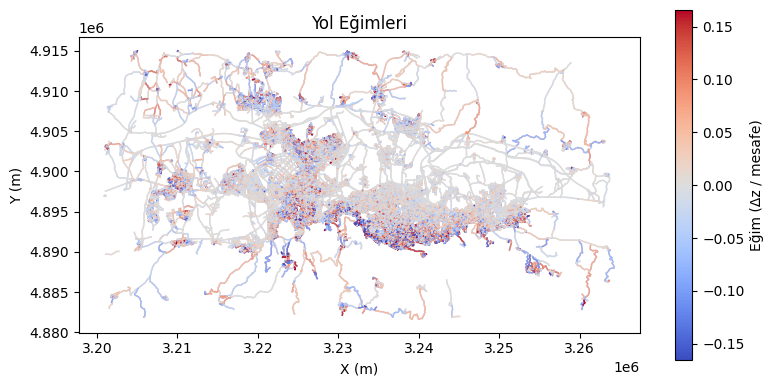

In [15]:
roads_slope_3857 = compute_road_slopes_from_raster(road_graph=roads_3857, data_plot=data_plot, mask_plot=mask_plot, transform=dst_transform)

plot_roads_by_slope(roads_slope_3857)

### Sipariş Verisinin Zenginleştirilmesi

#### Mahalle ve İlçe Verilerinin Eşleştirilmesi

In [16]:
enhanced_order_3857 = gpd.sjoin(order_3857, nbh_3857, how='left', predicate='within')
enhanced_order_3857 = enhanced_order_3857.drop(columns=['index_right'])
enhanced_order_3857 = gpd.sjoin(enhanced_order_3857, districts_3857, how='left', predicate='within')
# rename columns
enhanced_order_3857.rename(columns={'name_left': 'neighbourhood', 'guid_left': 'neighbourhood_id', 'name_right': 'district', 'delivery duration': 'delivery_duration'}, inplace=True)
# reorder columns
enhanced_order_3857 = enhanced_order_3857[['fid', 'order_id', 'client_id', 'profit', 'revenue', 'delivery_duration', 'neighbourhood', 'district', 'neighbourhood_id', 'district_id', 'geometry']]

#### En Yakın Depo Tespiti

1. **Yol Grafiğinde En Yakın Düğümün Bulunması**
   - Her sipariş ve depo noktası için, yol ağındaki en yakın düğüm (node) tespit edilir.
2. **Depolar İçin Dijkstra Algoritması ile Kısa Yol Hesaplama**
   - Her depo için, Dijkstra algoritması kullanılarak diğer tüm düğümlere (sipariş noktalarına) olan en kısa mesafe ve yol bilgisi hesaplanır.
3. **Siparişler İçin En Yakın Depo Seçimi ve Süre Hesaplama**
   - Her sipariş için, depolar arasından en kısa mesafeye sahip olan depo seçilir.
   - Seçilen depo ile sipariş noktası arasındaki en kısa yolun tahmini seyahat süresi hesaplanır.
   - Mesafe, süre ve ortalama hız bilgileri kaydedilir.
4. **Sonuçların Birleştirilmesi**
   - Tüm siparişler işlendiğinde, hesaplanan sonuçlar sipariş verisiyle birleştirilir.

In [17]:
# motorcycle speed profiles with respect to opernstreetmap road types
COURIER_SPEED = {
    'motorway': 90,    'trunk': 70,    'primary': 60,
    'secondary': 50,    'tertiary': 40,    'residential': 30,
    'living_street': 20,    'service': 25,    'unclassified': 35,
    'default': 40
}

# nearest nodes (warehouse -> order)
def get_nearest_nodes(gdf, graph):
    coords = np.column_stack([gdf.geometry.x, gdf.geometry.y])
    node_coords = np.array([[graph.nodes[n]['x'], graph.nodes[n]['y']] for n in graph.nodes()])
    
    tree = cKDTree(node_coords)
    _, indices = tree.query(coords)
    nodes = [list(graph.nodes())[i] for i in indices]
    return nodes

def find_closest_warehouse_with_time(orders_gdf, warehouses_gdf, road_graph):
    # source: https://github.com/gboeing/osmnx/blob/main/osmnx/distance.py
    order_nodes = get_nearest_nodes(orders_gdf, road_graph)
    wh_nodes = get_nearest_nodes(warehouses_gdf, road_graph)
    
    results = []
    failed_orders = 0
    # it's very slow to process all orders at once, so we process them in batches
    batch_size = 5000
    
    for batch_start in tqdm(range(0, len(order_nodes), batch_size), desc="paketler halinde hesaplanıyor"):
        batch_end = min(batch_start + batch_size, len(order_nodes))
        
        # run single-source dijkstra from each warehouse (distance-based)
        wh_distances = {}
        wh_paths = {}
        
        for wh_idx, wh_node in enumerate(wh_nodes):
            try:
                # Get both distances and paths
                distances, paths = nx.single_source_dijkstra(
                    road_graph, 
                    wh_node, 
                    cutoff=50000,  # 50km cutoff (it can be lowered)
                    weight='length'
                )
                wh_distances[wh_idx] = distances
                wh_paths[wh_idx] = paths
            except Exception as e:
                wh_distances[wh_idx] = {}
                wh_paths[wh_idx] = {}
        
        # Find closest warehouse for each order in batch
        for i in range(batch_start, batch_end):
            order_node = order_nodes[i]
            min_dist = float('inf')
            closest_wh = None
            best_path = None
            
            # Check distance from each warehouse to this order
            for wh_idx, distances in wh_distances.items():
                if order_node in distances:
                    dist = distances[order_node]
                    if dist < min_dist:
                        min_dist = dist
                        closest_wh = wh_idx
                        best_path = wh_paths[wh_idx].get(order_node, [])
            
            # Calculate travel time for the best path
            travel_time = None
            if best_path and len(best_path) > 1:
                travel_time = get_courier_travel_time(road_graph, best_path)
            
            if closest_wh is None:
                failed_orders += 1
            
            results.append({
                'order_id': orders_gdf.iloc[i]['order_id'],
                'closest_warehouse': warehouses_gdf.iloc[closest_wh]['Warehouse1'] if closest_wh is not None else None,
                'distance_m': min_dist if min_dist != float('inf') else None,
                'travel_time_min': travel_time,
                'avg_speed_kmh': (min_dist/1000) / (travel_time/60) if travel_time and travel_time > 0 else None
            })
    
    print(f"seyahat mesafesi hesaplandı. hatalı işlemler: {failed_orders}")
    return results

def get_courier_travel_time(road_graph, path):
    total_time = 0
    
    for i in range(len(path) - 1):
        edge_data = road_graph.get_edge_data(path[i], path[i+1])
        if edge_data:
            # Get first edge (in case of multiple edges)
            edge = list(edge_data.values())[0]
            
            # get length
            length = edge.get('length', 0)  # in meters
            
            # road type/highway classification
            highway = edge.get('highway', 'default')
            if isinstance(highway, list):
                highway = highway[0]
            
            # speed limit or use default for road type
            maxspeed = edge.get('maxspeed', None)
            if maxspeed:
                try:
                    speed_kmh = int(maxspeed.split()[0]) if isinstance(maxspeed, str) else maxspeed
                    # adding some realism to the speed limit and randomizing a little
                    speed_kmh = min(speed_kmh * random.uniform(1.05, 1.15), COURIER_SPEED.get(highway, 40))
                except:
                    speed_kmh = COURIER_SPEED.get(highway, 40)
            else:
                speed_kmh = COURIER_SPEED.get(highway, 40)
            
            # calculate time for this segment (seconds to minutes)
            segment_time = (length / 1000) / speed_kmh * 60
            total_time += segment_time

    return total_time

# run analysis
results = find_closest_warehouse_with_time(order_3857, wh_3857, roads_3857)

# join results with orders
enhanced_order_3857 = enhanced_order_3857.merge(pd.DataFrame(results), on='order_id', how='left')
enhanced_order_3857 = enhanced_order_3857[['fid', 'order_id', 'client_id', 'closest_warehouse', 'profit', 'revenue','distance_m', 'avg_speed_kmh', 'travel_time_min', 'delivery_duration', 'neighbourhood', 'district', 'neighbourhood_id', 'district_id', 'geometry']]

paketler halinde hesaplanıyor: 100%|██████████| 6/6 [00:24<00:00,  4.10s/it]

seyahat mesafesi hesaplandı. hatalı işlemler: 0


## Servis Alanları KPI Analizi

---

## Haritalandırma